In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import string
from tensorflow.keras import layers
from utility import process_md_lines

In [5]:
lines = open('/content/drive/MyDrive/hamdan/data.txt','r',encoding='utf-8').readlines()

In [6]:
df = process_md_lines(lines)

In [7]:
df.head()

,id,text,order,total_lines,url,label
0,0,هى عبارة حساسية عامة و شديدة تحدث في خلال دقائ...,0,22,https://www.123esaaf.com/Diseases/Anaphylaxis/...,definition
1,0,و المواد التى تسبب الحساسية المفرطة عديدة و مت...,1,22,https://www.123esaaf.com/Diseases/Anaphylaxis/...,definition
2,0,فمثلا حبوب اللقاح المتناثرة فى الجو قد تكون عا...,2,22,https://www.123esaaf.com/Diseases/Anaphylaxis/...,definition
3,0,تختلف الأعراض لمثل هذه الحالات فى شدتها بداية ...,3,22,https://www.123esaaf.com/Diseases/Anaphylaxis/...,Symptoms
4,0,تشمل الأعراض المصاحبة لهذا المرض ما يلى \n,4,22,https://www.123esaaf.com/Diseases/Anaphylaxis/...,Symptoms


In [8]:
tclasses = df['label'].unique()
no_classes = len(tclasses)
no_classes

5

In [9]:
df = df.sample(frac=1.0, random_state=101)
cut_off = int(len(df)*0.7)
train_df = df[:cut_off]
test_df = df[cut_off:]

In [10]:
X_train = train_df['text'].to_numpy()
X_test = test_df['text'].to_numpy()

In [11]:
y_train = pd.get_dummies(train_df['label']).to_numpy()
y_test = pd.get_dummies(test_df['label']).to_numpy()

In [12]:
vocab = set()
count = 0
char_count = 0
for text in df['text'].to_numpy():
    tokens = text.split()
    vocab.update(tokens)
    count+=len(tokens)
    char_count+= len(text)

In [13]:
VOCAB_SIZE = len(vocab)
VOCAB_SIZE

10231

In [14]:
char_lens = [len(sentence) for sentence in df['text'].to_numpy()]
CHAR_SEQ_LENGTH = int(np.percentile(char_lens, 95))
CHAR_SEQ_LENGTH

286

In [15]:
BATCH_SIZE = 32
WORD_EMBED_SIZE = 128

In [16]:
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [17]:
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token

In [18]:
char_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens= NUM_CHAR_TOKENS,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    output_sequence_length=CHAR_SEQ_LENGTH
)

In [19]:
text_chars = [" ".join(list(sentence)) for sentence in df['text'].to_numpy()]
char_vectorizer.adapt(text_chars)

In [20]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 70
5 most common characters: ['', '[UNK]', 'ا', 'ل', 'م']
5 least common characters: ['ً', 'v', '6', 'x', '8']


In [21]:
char_embedding = tf.keras.layers.Embedding(
    NUM_CHAR_TOKENS,
    25,
    mask_zero=False
)

In [22]:
model = tf.keras.models.Sequential([
    layers.Input(shape=[], dtype=tf.string),
    char_vectorizer,
    char_embedding,
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.Dropout(0.2),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(no_classes, activation='softmax')
])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 286)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 286, 25)           1750      
                                                                 
 bidirectional (Bidirectiona  (None, 286, 128)         46080     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 286, 128)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                        

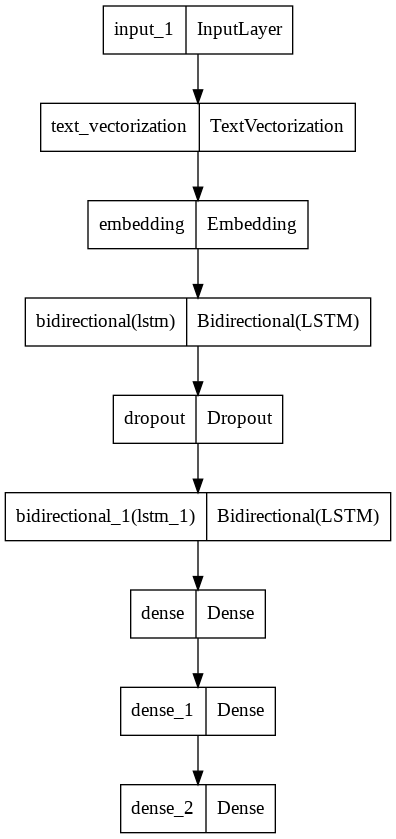

In [24]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [25]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [26]:
model.compile(loss="categorical_crossentropy",optimizer='adam', metrics=['accuracy'])

In [27]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=2,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False)

In [28]:
model.fit(train_ds, validation_data=test_ds, epochs=10, callbacks=[es])

Epoch 1/10
108/108 [==============================] - 83s 697ms/step - loss: 1.3795 - accuracy: 0.4244 - val_loss: 1.3352 - val_accuracy: 0.4581
Epoch 2/10
108/108 [==============================] - 87s 809ms/step - loss: 1.3343 - accuracy: 0.4485 - val_loss: 1.3199 - val_accuracy: 0.4621
Epoch 3/10
108/108 [==============================] - 74s 690ms/step - loss: 1.3272 - accuracy: 0.4543 - val_loss: 1.3145 - val_accuracy: 0.4614
Epoch 4/10
108/108 [==============================] - 76s 707ms/step - loss: 1.3224 - accuracy: 0.4569 - val_loss: 1.3034 - val_accuracy: 0.4587
Epoch 5/10
108/108 [==============================] - 74s 687ms/step - loss: 1.3105 - accuracy: 0.4627 - val_loss: 1.2893 - val_accuracy: 0.4892
Epoch 6/10
108/108 [==============================] - 76s 706ms/step - loss: 1.2957 - accuracy: 0.4766 - val_loss: 1.2576 - val_accuracy: 0.4939
Epoch 7/10
108/108 [==============================] - 76s 704ms/step - loss: 1.2819 - accuracy: 0.4856 - val_loss: 1.2499 - val_ac

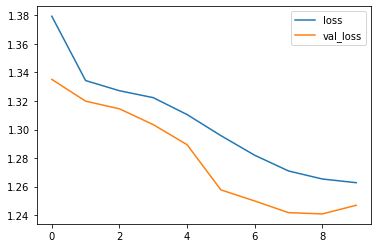

In [29]:
pd.DataFrame(model.history.history)[['loss','val_loss']].plot()

In [30]:
model.evaluate(test_ds)

47/47 [==============================] - 6s 131ms/step - loss: 1.2468 - accuracy: 0.4953


[1.2468271255493164, 0.49526387453079224]

In [31]:
r = np.random.randint(0,len(X_train))
text = X_train[r]
true_pred = y_train[r]
print(text)
print(true_pred)

الشعور الدائم بعدم الارتياح النفسى

[1 0 0 0 0]


In [32]:
myTensor = tf.convert_to_tensor(text, dtype=tf.string) 
myTensor = tf.expand_dims(myTensor,axis=-1)
class_index = np.argmax(model(myTensor))
class_index

0